In [1]:
!pip install datasets
!pip install transformers
!pip install torchvision
!pip install umap-learn
!pip install huggingface_hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, ClassLabel, interleave_datasets, concatenate_datasets
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from huggingface_hub import notebook_login
from torch.nn.functional import cross_entropy

print("\n")
print("All dependencies have been successfully installed and imported!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.3 MB/s eta 0:00

In [2]:
dataset = load_dataset("csv", data_files="final.csv")
dataset = dataset.rename_column("Target_class", "label")
dataset = dataset.shuffle(seed=42)

train_testvalid = dataset["train"].train_test_split(test_size=0.4)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
dataset = DatasetDict({
    "train": train_testvalid["train"],
    "validation": test_valid["test"],
    "test": test_valid["train"]})

# print(dataset)

train_ds = dataset["train"]
train_ds.features

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4cccafa38ca2c085/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

{'Patterns': Value(dtype='string', id=None),
 'Target': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

### **Oversampling**

Filter:   0%|          | 0/690 [00:00<?, ? examples/s]

Filter:   0%|          | 0/690 [00:00<?, ? examples/s]

Class 0: 127
Class 1: 132
Class 2: 133
Class 3: 126
Class 4: 131
Class 5: 117
Class 6: 135
Class 7: 112
Class 8: 129
Class 9: 118


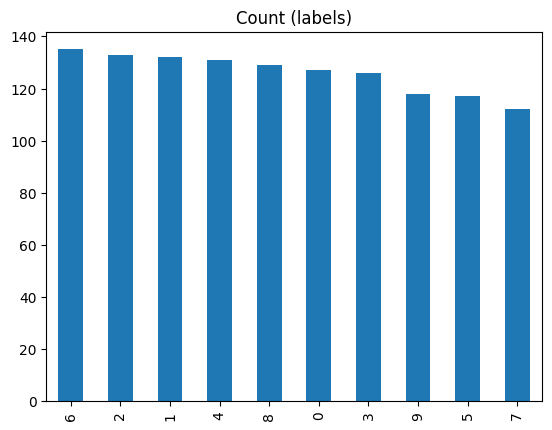

In [3]:
minority_dataset_23789 = dataset["train"].filter(lambda example: (example["label"] == 2) or (example["label"] == 3) or (example["label"] == 7) or (example["label"] == 8) or (example["label"] == 9))
minority_dataset_1 = dataset["train"].filter(lambda example: example["label"] == 1)

interleaved_dataset = interleave_datasets([dataset["train"], minority_dataset_23789, minority_dataset_1], seed = 42, probabilities = [0.6, 0.35, 0.05], stopping_strategy = "all_exhausted")

# Display count of each class after oversampling
target_count = pd.Series(interleaved_dataset["label"]).value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])
print('Class 4:', target_count[4])
print('Class 5:', target_count[5])
print('Class 6:', target_count[6])
print('Class 7:', target_count[7])
print('Class 8:', target_count[8])
print('Class 9:', target_count[9])

target_count.plot(kind='bar', title='Count (labels)');

In [4]:
dataset["train"] = interleaved_dataset

### **Tokenizing**

In [5]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [6]:
def tokenize(batch):
    return tokenizer(batch["Patterns"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

### **Training the model**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [9]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_test = np.array(dataset_hidden["test"]["label"])

X_train.shape, X_valid.shape, X_test.shape

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

((1260, 768), (230, 768), (230, 768))

### **PCA and Visualizing each class**

In [10]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-6.411518,1.293653,9
1,3.324497,-2.082767,6
2,23.221727,19.028084,9
3,0.495707,22.920458,2
4,5.699710,25.433964,1


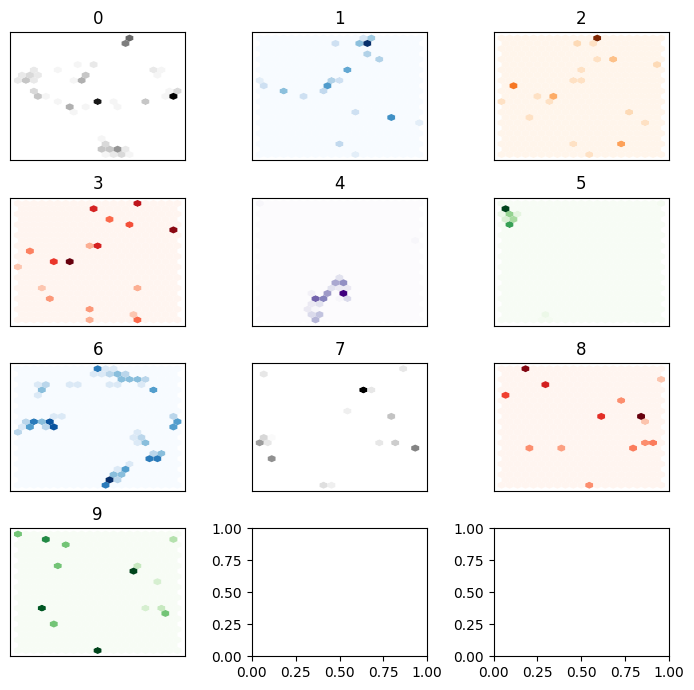

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(7,7))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "Blues", "Greys", "Reds", "Greens"]
labels = set(dataset["train"]["label"])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                  gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

In [12]:
# to test on train and validation sets
X_train_valid = np.vstack((X_train,X_valid))
y_train_valid = np.append(y_train,y_valid)

**Logistic Regression**

In [13]:
# Training classifiers with different parameters to check which is the best model

# Classifier 0 -> default parameters
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

# Classifier 1 -> solver= 'newton-cg', C=0.1
lr_clf1 = LogisticRegression(solver= 'newton-cg', C=0.1, max_iter=3000)
lr_clf1.fit(X_train, y_train)

# Classifier 2 -> solver= 'newton-cg', C=1.0
lr_clf2 = LogisticRegression(solver= 'newton-cg', C=1.0, max_iter=3000)
lr_clf2.fit(X_train, y_train)

# Classifier 3 -> solver= 'newton-cg', C=10
lr_clf3 = LogisticRegression(solver= 'newton-cg', C=10, max_iter=3000)
lr_clf3.fit(X_train, y_train)

# Classifier 4 -> solver= 'sag', C=100
lr_clf4 = LogisticRegression(solver= 'newton-cg', C=100, max_iter=3000)
lr_clf4.fit(X_train, y_train)

# Classifier 5 -> solver= 'sag', C=0.1
lr_clf5 = LogisticRegression(solver= 'sag', C=0.1, max_iter=3000)
lr_clf5.fit(X_train, y_train)

# Classifier 6 -> solver= 'sag', C=1.0
lr_clf6 = LogisticRegression(solver= 'sag', C=1.0, max_iter=3000)
lr_clf6.fit(X_train, y_train)

# Classifier 7 -> solver= 'sag', C=10
lr_clf7 = LogisticRegression(solver= 'sag', C=10, max_iter=3000)
lr_clf7.fit(X_train, y_train)

# Classifier 8 -> solver= 'sag', C=100
lr_clf8 = LogisticRegression(solver= 'sag', C=100, max_iter=3000)
lr_clf8.fit(X_train, y_train)

# Classifier 9 -> solver= 'liblinear', C=1.0
lr_clf9 = LogisticRegression(solver= 'liblinear', C=1.0, max_iter=3000)
lr_clf9.fit(X_train, y_train)

# Classifier 10 -> solver= 'liblinear', C=10
lr_clf10 = LogisticRegression(solver= 'liblinear', C=10, max_iter=3000)
lr_clf10.fit(X_train, y_train)

# Classifier 11 -> solver= 'liblinear', C=100
lr_clf11 = LogisticRegression(solver= 'liblinear', C=100, max_iter=3000)
lr_clf11.fit(X_train, y_train)

# Classifier 12 -> solver= 'lbfgs', C=1.0
lr_clf12 = LogisticRegression(solver= 'lbfgs', C=1.0, max_iter=3000)
lr_clf12.fit(X_train, y_train)

# Classifier 13 -> solver= 'lbfgs', C=10
lr_clf13 = LogisticRegression(solver= 'lbfgs', C=10, max_iter=3000)
lr_clf13.fit(X_train, y_train)

# Classifier 14 -> solver= 'lbfgs', C=100
lr_clf14 = LogisticRegression(solver= 'lbfgs', C=100, max_iter=3000)
lr_clf14.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(C=100, max_iter=3000)

In [14]:
# Testing on train + validation set and test set

print("Scores on train + valid set")
print("clf0: ", lr_clf.score(X_train_valid, y_train_valid))
print("clf1: ", lr_clf1.score(X_train_valid, y_train_valid))
print("clf2: ", lr_clf2.score(X_train_valid, y_train_valid))
print("clf3: ", lr_clf3.score(X_train_valid, y_train_valid))
print("clf4: ", lr_clf4.score(X_train_valid, y_train_valid))
print("clf5: ", lr_clf5.score(X_train_valid, y_train_valid))
print("clf6: ", lr_clf6.score(X_train_valid, y_train_valid))
print("clf7: ", lr_clf7.score(X_train_valid, y_train_valid))
print("clf8: ", lr_clf8.score(X_train_valid, y_train_valid))
print("clf9: ", lr_clf9.score(X_train_valid, y_train_valid))
print("clf10: ", lr_clf10.score(X_train_valid, y_train_valid))
print("clf11: ", lr_clf11.score(X_train_valid, y_train_valid))
print("clf12: ", lr_clf12.score(X_train_valid, y_train_valid))
print("clf13: ", lr_clf13.score(X_train_valid, y_train_valid))
print("clf14: ", lr_clf14.score(X_train_valid, y_train_valid))

print("---------------------------")

print("Scores on test set")
print("clf0: ", lr_clf.score(X_test, y_test))
print("clf1: ", lr_clf1.score(X_test, y_test))
print("clf2: ", lr_clf2.score(X_test, y_test))
print("clf3: ", lr_clf3.score(X_test, y_test))
print("clf4: ", lr_clf4.score(X_test, y_test))
print("clf5: ", lr_clf5.score(X_test, y_test))
print("clf6: ", lr_clf6.score(X_test, y_test))
print("clf7: ", lr_clf7.score(X_test, y_test))
print("clf8: ", lr_clf8.score(X_test, y_test))
print("clf9: ", lr_clf9.score(X_test, y_test))
print("clf10: ", lr_clf10.score(X_test, y_test))
print("clf11: ", lr_clf11.score(X_test, y_test))
print("clf12: ", lr_clf12.score(X_test, y_test))
print("clf13: ", lr_clf13.score(X_test, y_test))
print("clf14: ", lr_clf14.score(X_test, y_test))

Scores on train + valid set
clf0:  1.0
clf1:  0.9959731543624161
clf2:  1.0
clf3:  1.0
clf4:  1.0
clf5:  0.9959731543624161
clf6:  1.0
clf7:  1.0
clf8:  0.9993288590604027
clf9:  1.0
clf10:  1.0
clf11:  1.0
clf12:  1.0
clf13:  1.0
clf14:  1.0
---------------------------
Scores on test set
clf0:  1.0
clf1:  0.9956521739130435
clf2:  1.0
clf3:  1.0
clf4:  1.0
clf5:  0.9956521739130435
clf6:  1.0
clf7:  1.0
clf8:  0.9956521739130435
clf9:  1.0
clf10:  0.9956521739130435
clf11:  0.9956521739130435
clf12:  1.0
clf13:  1.0
clf14:  1.0


**Random Forest**

In [16]:
# Training classifiers with different parameters to check which is the best model

# Classifier 0 -> default parameters
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Classifier 1 -> n_estimators=200, max_depth=5
rf_clf1 = RandomForestClassifier(n_estimators = 200, max_depth = 5)
rf_clf1.fit(X_train, y_train)

# Classifier 2 -> n_estimators = 500
rf_clf2 = RandomForestClassifier(n_estimators = 500)
rf_clf2.fit(X_train, y_train)

# Classifier 3 -> n_estimators=500, max_depth=10
rf_clf3 = RandomForestClassifier(n_estimators = 500, max_depth = 10)
rf_clf3.fit(X_train, y_train)

# Classifier 4 -> n_estimators=500, max_depth=20
rf_clf4 = RandomForestClassifier(n_estimators = 500, max_depth = 20)
rf_clf4.fit(X_train, y_train)

# Classifier 5 -> n_estimators=600, max_depth=20
rf_clf5 = RandomForestClassifier(n_estimators = 600, max_depth = 20)
rf_clf5.fit(X_train, y_train)

# Classifier 6 -> n_estimators=600, max_depth=20, random_state=42
rf_clf6 = RandomForestClassifier(n_estimators = 600, max_depth = 20, random_state = 42)
rf_clf6.fit(X_train, y_train)

# Classifier 7 -> n_estimators=600, max_depth=20, random_state=35
rf_clf7 = RandomForestClassifier(n_estimators = 600, max_depth = 20, random_state = 35)
rf_clf7.fit(X_train, y_train)

# Classifier 8 -> n_estimators=600, max_depth=20, random_state=0
rf_clf8 = RandomForestClassifier(n_estimators = 600, max_depth = 20, random_state = 0)
rf_clf8.fit(X_train, y_train)

# Classifier 9 -> n_estimators=600, criterion="entropy", max_depth=20, random_state=42
rf_clf9 = RandomForestClassifier(n_estimators = 600, criterion = "entropy", max_depth = 20, random_state = 42)
rf_clf9.fit(X_train, y_train)

# Classifier 10 -> n_estimators=600, criterion="log_loss", max_depth=20, random_state=42
rf_clf10 = RandomForestClassifier(n_estimators = 600, criterion = "log_loss", max_depth = 20, random_state = 42)
rf_clf10.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=600,
                       random_state=42)

In [17]:
# Testing on train + validation set and test set

print("Scores on train + valid set")
print("clf0: ", rf_clf.score(X_train_valid, y_train_valid))
print("clf1: ", rf_clf1.score(X_train_valid, y_train_valid))
print("clf2: ", rf_clf2.score(X_train_valid, y_train_valid))
print("clf3: ", rf_clf3.score(X_train_valid, y_train_valid))
print("clf4: ", rf_clf4.score(X_train_valid, y_train_valid))
print("clf5: ", rf_clf5.score(X_train_valid, y_train_valid))
print("clf6: ", rf_clf6.score(X_train_valid, y_train_valid))
print("clf7: ", rf_clf7.score(X_train_valid, y_train_valid))
print("clf8: ", rf_clf8.score(X_train_valid, y_train_valid))
print("clf9: ", rf_clf9.score(X_train_valid, y_train_valid))
print("clf10: ", rf_clf10.score(X_train_valid, y_train_valid))

print("---------------------------")

print("Scores on test set")
print("clf0: ", rf_clf.score(X_test, y_test))
print("clf1: ", rf_clf1.score(X_test, y_test))
print("clf2: ", rf_clf2.score(X_test, y_test))
print("clf3: ", rf_clf3.score(X_test, y_test))
print("clf4: ", rf_clf4.score(X_test, y_test))
print("clf5: ", rf_clf5.score(X_test, y_test))
print("clf6: ", rf_clf6.score(X_test, y_test))
print("clf7: ", rf_clf7.score(X_test, y_test))
print("clf8: ", rf_clf8.score(X_test, y_test))
print("clf9: ", rf_clf9.score(X_test, y_test))
print("clf10: ", rf_clf10.score(X_test, y_test))

Scores on train + valid set
clf0:  0.9959731543624161
clf1:  0.9939597315436242
clf2:  0.9966442953020134
clf3:  0.9959731543624161
clf4:  0.9966442953020134
clf5:  0.9959731543624161
clf6:  0.9959731543624161
clf7:  0.9966442953020134
clf8:  0.9959731543624161
clf9:  0.9959731543624161
clf10:  0.9959731543624161
---------------------------
Scores on test set
clf0:  0.9695652173913043
clf1:  0.9565217391304348
clf2:  0.9652173913043478
clf3:  0.9608695652173913
clf4:  0.9652173913043478
clf5:  0.9608695652173913
clf6:  0.9608695652173913
clf7:  0.9652173913043478
clf8:  0.9652173913043478
clf9:  0.9608695652173913
clf10:  0.9608695652173913


### **Fine-Tuning Distilbert**

In [18]:
num_labels = 10
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [42]:
# Need to login to notebook using access token (refer to the hf_login_token file)
notebook_login()

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is be

In [22]:
batch_size = 64
logging_steps = len(dataset_hidden["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-FYP"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_hidden['train'],
    eval_dataset=dataset_hidden['validation'],
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.143500,1.790332,0.769565,0.746188
2,1.544900,1.054892,0.956522,0.960346
3,1.000800,0.579978,0.991304,0.991179
4,0.625200,0.331113,0.995652,0.995654
5,0.383300,0.207612,0.995652,0.995654
6,0.249600,0.146965,0.995652,0.995654
7,0.182000,0.117327,0.995652,0.995654
8,0.147500,0.101705,0.995652,0.995654
9,0.127900,0.094442,0.995652,0.995654
10,0.119700,0.092142,0.995652,0.995654


TrainOutput(global_step=200, training_loss=0.6256372457742692, metrics={'train_runtime': 33.6695, 'train_samples_per_second': 374.226, 'train_steps_per_second': 5.94, 'total_flos': 81510124500000.0, 'train_loss': 0.6256372457742692, 'epoch': 10.0})

In [23]:
# Concatenating train and validation datasets for testing
dataset_hidden_train_val = concatenate_datasets([dataset_hidden["train"], dataset_hidden["validation"]])

In [24]:
print("Validation set scores")
preds_output_val = trainer.predict(dataset_hidden["validation"])
print(preds_output_val.metrics)

print("-----------------------------")

print("Train + Validation set scores")
preds_output_train_val = trainer.predict(dataset_hidden_train_val)
print(preds_output_train_val.metrics)

print("-----------------------------")

print("Test set scores")
preds_output_test = trainer.predict(dataset_hidden["test"])
print(preds_output_test.metrics)

Validation set scores


{'test_loss': 0.09214194118976593, 'test_accuracy': 0.9956521739130435, 'test_f1': 0.9956535681173361, 'test_runtime': 0.2418, 'test_samples_per_second': 951.184, 'test_steps_per_second': 16.542}
-----------------------------
Train + Validation set scores


{'test_loss': 0.08845777809619904, 'test_accuracy': 0.9993288590604027, 'test_f1': 0.9993287608191966, 'test_runtime': 1.2123, 'test_samples_per_second': 1229.04, 'test_steps_per_second': 19.797}
-----------------------------
Test set scores


{'test_loss': 0.08756507188081741, 'test_accuracy': 1.0, 'test_f1': 1.0, 'test_runtime': 0.154, 'test_samples_per_second': 1493.603, 'test_steps_per_second': 25.976}


In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

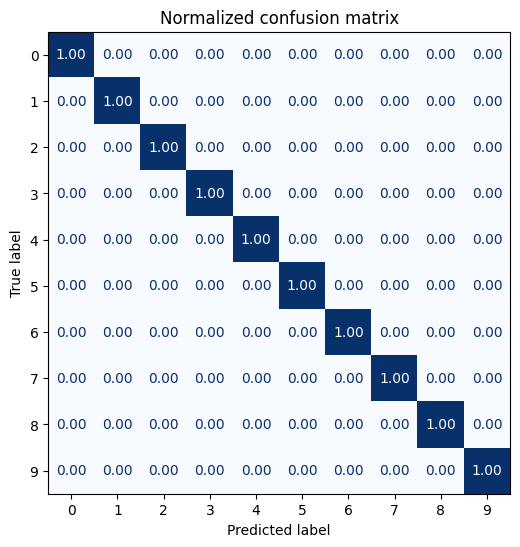

In [26]:
# Confusion Matrix

y_preds = np.argmax(preds_output_test.predictions, axis=1)
plot_confusion_matrix(y_preds, y_test, labels)

In [27]:
def forward_pass_with_label(batch):
  # place all input tensors on the same device as model
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis = -1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction = "none")

    #place outputs on cpu for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted label": pred_label.cpu().numpy()}

# convert our dataset back to pytorch tensors
dataset_hidden.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

dataset_hidden["validation"] = dataset_hidden["validation"].map(forward_pass_with_label, batched = True, batch_size = 16)

# Convert dataset to pandas for custom testing
dataset_hidden.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

In [43]:
# Save finetuned model in huggingface repository for predictions
trainer.push_to_hub(commit_message = "Training completed!")
print("Pushing done!")

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
Cloning https://huggingface.co/tanishabhagwanani/distilbert-base-uncased-finetuned-FYP into local empty directory.
It seems that the gevent monkey-patching is being used.
Please set an environment variable

Download file pytorch_model.bin:   0%|          | 16.5k/255M [00:00<?, ?B/s]

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is be

Download file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##8       | 1.00k/3.50k [00:00<?, ?B/s]

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is be

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is be

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.50k [00:00<?, ?B/s]

It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is being used.
Please set an environment variable with:
GEVENT_SUPPORT=True
to enable gevent support in the debugger.
It seems that the gevent monkey-patching is be

In [30]:
model_id = "tanishabhagwanani/distilbert-base-uncased-finetuned-FYP"
classifier = pipeline("text-classification", model=model_id)

In [31]:
custom_question = "Display a bar chart of Age against Salary"
preds = classifier(custom_question, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
preds_df

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,label,score
0,LABEL_0,0.003974
1,LABEL_1,0.004519
2,LABEL_2,0.004950
3,LABEL_3,0.004536
4,LABEL_4,0.006290
5,LABEL_5,0.003830
6,LABEL_6,0.006732
7,LABEL_7,0.957785
8,LABEL_8,0.004553
9,LABEL_9,0.002831


In [32]:
# Delete this

preds_df = pd.DataFrame(preds[0])
preds_df.score

0    0.003974
1    0.004519
2    0.004950
3    0.004536
4    0.006290
5    0.003830
6    0.006732
7    0.957785
8    0.004553
9    0.002831
Name: score, dtype: float64

In [33]:
np.argmax(preds_df.score)

7

In [34]:
target_arr = ["df['col1'].nunique()",
             "df.sort_values(by=['col1'],inplace =True)",
             "df.sort_values(by=['col1', 'col2'],inplace =True)",
             "df.sort_values(by=['col1', 'col2', 'col3'],inplace =True)",
             "df.drop(columns = 'col1',inplace = True)",
             "new_df=df.loc[:, ['col1','col2']]",
             "df['col1'].value_counts()",
             "<|{dataset}|chart|type=bar|x=col1|y=col2|height=100%|>",
             "<|{dataset}|chart|type=pie|values=col2|labels=col1|height=100%|>",
             "<|{dataset}|chart|mode=lines|x=col1|y=col2|>"]

In [35]:
df = pd.read_csv("sample_dataframe.csv")
cols = df.columns
cols

Index(['ID', 'Name', 'Salary', 'Age', 'Position', 'Address'], dtype='object')

In [36]:
sentence = custom_question
# print(sentence.split())
words = sentence.split()
cols_requested = []
for item in cols:
  # print(item)
  for word in words:
    if(item.upper() == word.upper()):
        cols_requested.append(item)

cols_requested

['Salary', 'Age']

In [37]:
general_sentence = sentence
for i in range(len(cols_requested)):
    general_sentence = general_sentence.replace(cols_requested[i], "col" + str(i+1))
general_sentence

'Display a bar chart of col2 against col1'

In [38]:
!pip install taipy

In [39]:
from taipy.gui import Gui

In [40]:
prediction_int = np.argmax(preds_df.score)
if prediction_int < 7:
    panda_query = target_arr[np.argmax(preds_df.score)]
    panda_query
    for i in range(len(cols_requested)):
        panda_query = panda_query.replace("col" + str(i+1), cols_requested[i])
    exec(panda_query)
    df
else: 
    taipy_query = target_arr[prediction_int]
    dataset = df
    for i in range(len(cols_requested)):
        taipy_query = taipy_query.replace("col" + str(i+1), cols_requested[i])
    page = """{0}"""
    page = page.format(taipy_query)
    gui = Gui(page)
    gui.run()

INFO:Taipy:Running in 'single_client' mode in notebook environment
INFO:Taipy: * Server starting on http://127.0.0.1:5000
